<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_HR_gr1/blob/main/Kiparenko%20Nikolai/INSPECTRUM_CLINIC_HR_RECSYS_GR1_AUTO_ML_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INSPECTRUM CLINIC HR RECSYS

Рассмотрим вариант создание нейронной сети с помощью инструментов **AvtoML**

В техническом задании прописаны критерии которым должны соответствовать наши модели:

1.  Система должна помогать HR-специалисту вынести решение о том, подходит или не подходит человек на рассматриваемую должность.
2.  В датасете целевым столбцом для предсказания является столбец под названием “Подходит - да/нет”.
3.  Результатом работы обученной нейросети должно служить дополнение датасета столбцом под названием “оценка резюме”, где должно быть представлено процентное распределение вероятностей между классами “подходит” и “не подходит”. Например: "подходит 95% / не подходит 5%".


### Загрузим библиотеки

In [1]:
# Загрузка датасетов из облака
import gdown

# Функции операционной системы
import os

# Работа с массивами данных
import numpy as np

# Работа с таблицами
import pandas as pd

# автоматически парсит строку и сохранит ее в переменной datetime
import datetime

# Токенизатор для преобразование текстов в последовательности
from tensorflow.keras.preprocessing.text import Tokenizer

# Отрисовка графиков
import matplotlib.pyplot as plt
import seaborn as sns # Будем визулизировать данные этой библиотекой

# Метрики для расчета ошибок
from sklearn.metrics import mean_squared_error, mean_absolute_error



### Инициализация библиотек AvtoML

Инициализация может занять некоторое время

In [2]:
# H2OAutoML
!pip install h2o
import h2o
from h2o.automl import H2OAutoML
h2o.init()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 MB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.42.0.1-py2.py3-none-any.whl size=249152215 sha256=2e3399dc3f6f53932faabd149748b835b71aae3b6248acb11d4b5f4ae4b0af9d
  Stored in directory: /root/.cache/pip/wheels/2e/2f/04/ef0554c89bcb5d38a6fc082a87f497933109faefd94dcdc3d2
Successfully built h2o
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.19" 2023-04-18; OpenJDK Runtime Environment (build 11.0.19+7-post-Ubuntu-0ubuntu120.04.1); OpenJDK 64-Bit Server VM (build 11.0.19+7-post-Ubuntu-0ubuntu120.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpea0h93qp
  JVM stdout: /tmp/tmpea0h93qp/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpea0h93qp/h2o_unknownUser_star

H2O_cluster_uptime:,05 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.1
H2O_cluster_version_age:,"28 days, 18 hours and 21 minutes"
H2O_cluster_name:,H2O_from_python_unknownUser_uauoh5
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


### Далее загрузим наш датасет и рассмотрим его

In [104]:
#Грузим файл
path = "https://docs.google.com/spreadsheets/d/1tcfBgGY98cFx1DIvmoRy7goHXNcnaBZ7/export?format=xlsx"
gdown.download(path,'dataS.xlsx', quiet=True)

/usr/local/lib/python3.10/dist-packages/gdown/parse_url.py:35: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=None
  warnings.warn(


'dataS.xlsx'

Файл содержит в себе множество текстовых полей, постараемся рассмотреть их более внимательно

In [105]:
#Читаем файл
data = pd.read_excel (r'dataS.xlsx', index_col=0)
data.to_csv('data.csv')
data.head(5)

,Дата отклика,"Пол, возраст",ЗП,Ищет работу на должность,Город,Занятость,График,Опыт (),Последнее/нынешное место работы,Последняя/нынешняя должность,Выполняемые задачи на прошлых местах работ,Обо мне,Ключевые навыки,Образование и ВУЗ,Обновление резюме,Подходит - да/нет
0,2023-02-23 00:00:00,Женщина,90 000 руб.,Growth Product Manager,"Индонезия, Не готова к переезду, не готова к к...","проектная работа, частичная занятость, полная ...",удаленная работа,Опыт работы —5 лет 10 месяцев,PT MYBALI APP GROUP,Менеджер по продукту,Маркетинговые исследования\nИсследование рынка...,NaN,Анализ рынка\nУправление проектами\nProduct Ma...,"Высшее, 2023, Нетоло́гия, 2014, Университет Ро...",23 февраля 2023 в 16:30,да
1,2023-01-11 00:00:00,Женщина,не указана,Growth Product Manager,"Москва, Готова к переезду, готова к командировкам",полная занятость,"удаленная работа, гибкий график, полный день",Опыт работы —11 лет 11 месяцев,Банк Открытие,Product owner трайб сбережения и инвестиции,Участие в команде роста\nВ2В\n\nЗадачи:\n- Раз...,NaN,Самомотивация\nТаймменеджмент\nКреативность\nЧ...,"Высшее, 2022, GeekBrains, 2010, Московский худ...",8 февраля 2023 в 09:15,да
2,2023-02-27 00:00:00,"Мужчина, 33 года, родился 23 августа 1989",150 000 руб.,Growth Product Manager,"Санкт-Петербург, Готов к переезду: Москва, гот...","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день",Опыт работы —7 лет 2 месяца,DIKIY LLC,,Запуск бренда и производства игристого кваса D...,"Чем бы я ни занимался с 2014 года, когда решил...",Продвижение бренда\nПланирование маркетинговых...,"Высшее, 2013, Санкт-Петербургский государствен...",28 февраля 2023 в 09:41,да
3,2023-01-11 00:00:00,"Мужчина, 32 года, родился 7 декабря 1990",не указана,Growth Product Manager,"Москва, м. Молодежная, Хочу переехать, готов к...","стажировка, частичная занятость, полная занятость","удаленная работа, гибкий график, полный день",Опыт работы —8 лет 10 месяцев,WeInvest,Product Manager (team leader),1. Исследование рынка\n2. Определение целевой ...,"Я проактивный, коммуникабельный, позитивный, д...",Управление проектами\nОрганизаторские навыки\n...,"Магистр, 2014, Московский государственный техн...",24 января 2023 в 12:07,да
4,2023-01-11 00:00:00,"Мужчина, 26 лет, родился 21 февраля 1996",150 000 руб.,Growth Product Manager,"Пермь, Хочу переехать, готов к командировкам","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день",Опыт работы —5 лет 9 месяцев,Индивидуальное предпринимательство / частная п...,Product/Project manager,Переговоры со стейкхолдером\n- Составление ТЗ...,Набрал кучу опыта и хочу с ним найти классную ...,Управление персоналом\nЗаключение договоров\nА...,"Высшее, 2021, Российская академия народного хо...",6 февраля 2023 в 11:18,да


Видим что у нас много "нет" и всего 11 "да" на весь датасет

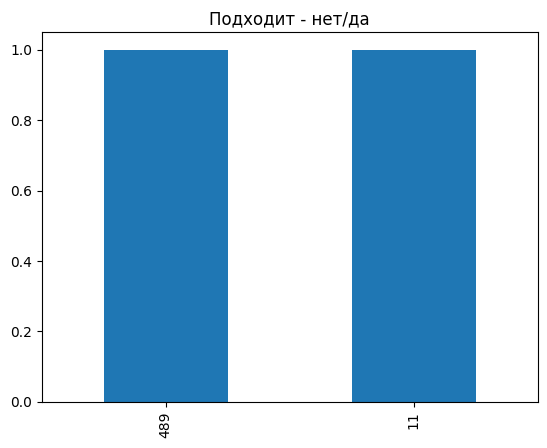

In [88]:
#Смотрим на распределение признаков Подходит - да/нет
countsSuitable = data['Подходит - да/нет'].value_counts()
countsSuitable.value_counts().plot(kind='bar', label='Suitable')
plt.title('Подходит - нет/да')
plt.show()


Больше всего "да" у Growth Product Manager (5) и HR-специалист(4)

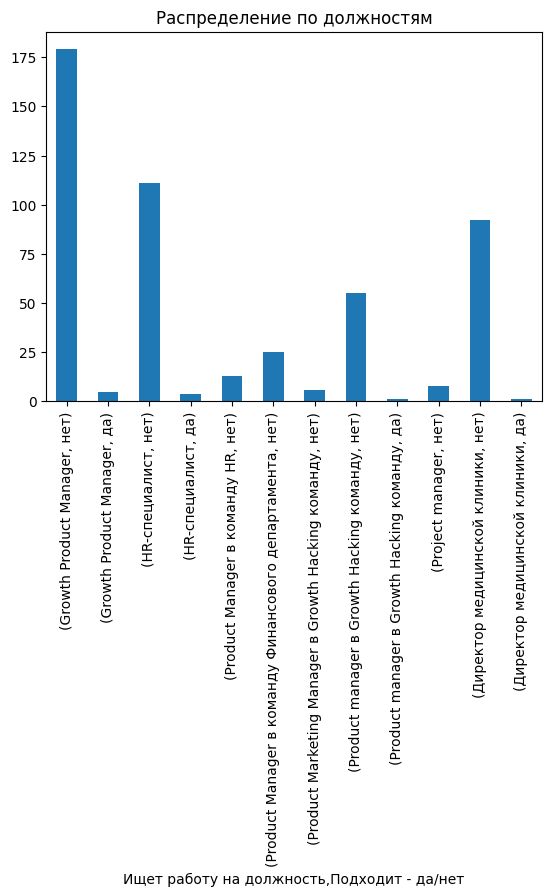

Ищет работу на должность                            Подходит - да/нет
Growth Product Manager                              нет                  179
                                                    да                     5
HR-специалист                                       нет                  111
                                                    да                     4
Product Manager в команду HR                        нет                   13
Product Manager в команду Финансового департамента  нет                   25
Product Marketing Manager в Growth Hacking команду  нет                    6
Product manager в Growth Hacking команду            нет                   55
                                                    да                     1
Project manager                                     нет                    8
Директор медицинской клиники                        нет                   92
                                                    да                     1
Name: 

In [23]:
#Смотрим на распределение признаков относительно должностей
countsJob = data.groupby('Ищет работу на должность')['Подходит - да/нет'].value_counts()
countsJob.plot(kind='bar', label='Suitable')
plt.title('Распределение по должностям')
plt.show()

countsJob

Такой не сбалансированный датасет обычно не подходит для обучения но мы постараемся немного его нормализовать

Переименуем всех Product Manager в одну категорию

In [106]:
#Growth Product Manager
#Product Manager в команду HR
#Product Manager в команду Финансового департамента
#Product Marketing Manager в Growth Hacking команду
#Product manager в Growth Hacking команду
#Project manager
for i, row in data.iterrows():
  if row['Ищет работу на должность'].find("Product") >= 0:
      row['Ищет работу на должность'] =  "Project manager"


Выберем все категории записи с положительным ответом и добавим случайные данные с отрицательным ответом, пропорционально.

In [107]:
#Manager
dataMa = data.loc[(data['Ищет работу на должность'] == 'Project manager')]
dataDA = dataMa.loc[(data['Подходит - да/нет'] == 'да')]
dataDA = dataDA.iloc[:6]
dataNA = dataMa.loc[(data['Подходит - да/нет'] == 'нет')]
dataNA = dataNA.sample(frac=1)
dataNA = dataNA.iloc[:80]

dataMa = pd.merge(dataDA,dataNA, how='outer')

#HR-специалист
dataHR = data.loc[(data['Ищет работу на должность'] == 'HR-специалист')]
dataDAHR = dataHR.loc[(data['Подходит - да/нет'] == 'да')]
dataDAHR = dataDAHR.iloc[:4]
dataNAHR = dataHR.loc[(data['Подходит - да/нет'] == 'нет')]
dataNAHR = dataNAHR.sample(frac=1)
dataNAHR = dataNAHR.iloc[:60]

dataHR = dataDAHR.merge(dataNAHR, how='outer')

#Директор
dataDr = data.loc[(data['Ищет работу на должность'] == 'Директор медицинской клиники')]
dataDADr = dataDr.loc[(data['Подходит - да/нет'] == 'да')]
dataDADr = dataDADr.iloc[:1]
dataNADr = dataDr.loc[(data['Подходит - да/нет'] == 'нет')]
dataNADr = dataNADr.sample(frac=1)
dataNADr = dataNADr.iloc[:20]

dataDr = dataDADr.merge(dataNADr, how='outer')

#Объединяем
data = pd.merge(dataMa,dataHR, how='outer')
data = pd.merge(data,dataDr, how='outer')

data = data.sample(frac=1)

<ipython-input-107-1b8031472646>:29: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  dataDr = dataDADr.merge(dataNADr, how='outer')


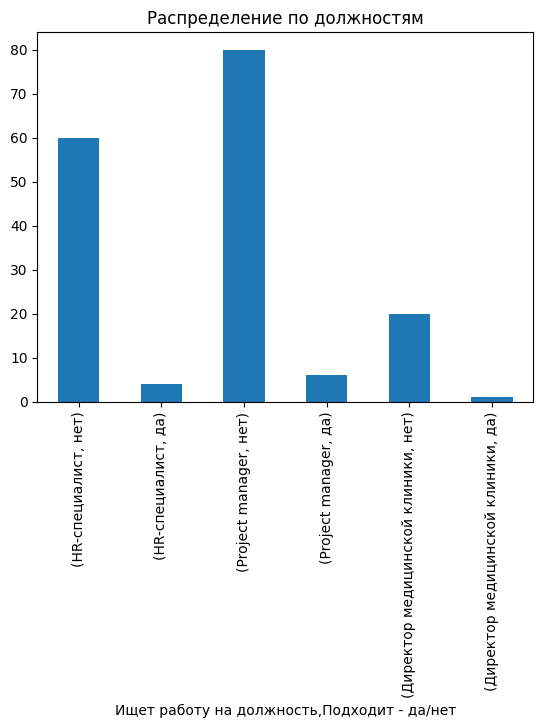

Ищет работу на должность      Подходит - да/нет
HR-специалист                 нет                  60
                              да                    4
Project manager               нет                  80
                              да                    6
Директор медицинской клиники  нет                  20
                              да                    1
Name: Подходит - да/нет, dtype: int64

In [91]:
#Смотрим на распределение признаков относительно должностей
countsJob = data.groupby('Ищет работу на должность')['Подходит - да/нет'].value_counts()
countsJob.plot(kind='bar', label='Suitable')
plt.title('Распределение по должностям')
plt.show()

countsJob


Сохраняем чистый датафрейм в файл

In [108]:
data.to_csv('data_c.csv')
data.head(5)

,Дата отклика,"Пол, возраст",ЗП,Ищет работу на должность,Город,Занятость,График,Опыт (),Последнее/нынешное место работы,Последняя/нынешняя должность,Выполняемые задачи на прошлых местах работ,Обо мне,Ключевые навыки,Образование и ВУЗ,Обновление резюме,Подходит - да/нет
119,2023-02-07 00:00:00,"Женщина, 25 лет, родилась 23 июня 1997",35 000 руб.,HR-специалист,"Уфа, Не готова к переезду, готова к редким ком...",полная занятость,полный день,Опыт работы —2 года 10 месяцев,Бодрость,Психолог,Коррекционно-развивающая работа с детьми - инв...,К работе отношусь добросовестно и с необходимо...,MS PowerPoint\nДеловое общение\nРабота в коман...,"Высшее, 2019, Башкирский государственный униве...",27 февраля 2023 в 15:20,нет
106,2023-01-12 00:00:00,"Женщина, 26 лет, родилась 7 мая 1996",40 000 руб.,HR-специалист,"Уфа, Не готова к переезду, готова к редким ком...","полная занятость, частичная занятость, проектн...",удаленная работа,Опыт работы —4 года 6 месяцев,ООО «Класс Информационные Технологии» https://...,HR менеджер,"Поиск, подбор персонала (линейный, точечный);\...",Опыт в сфере массового и точечного подбора пер...,CRM\nПодбор персонала\nПрямой поиск\nИнтервьюи...,"Высшее, 2018, Уфимский государственный авиацио...",23 марта 2023 в 15:46,нет
145,2023-02-07 00:00:00,Женщина,20 000 руб.,HR-специалист,"Уфа, Не готова к переезду, не готова к команди...",полная занятость,полный день,Опыт работы —2 месяца,ИП РАМАЗАНОВА Г.А.,Менеджер по работе с клиентами,NaN,NaN,NaN,"Среднее специальное, 2022, Колледж БГПУ им. М....",9 марта 2023 в 10:36,нет
163,2023-02-14 00:00:00,"Женщина, 45 лет, родилась 15 августа 1977",не указана,Директор медицинской клиники,"Уфа, Готова к переезду: Москва, Санкт-Петербур...",полная занятость,полный день,Опыт работы —25 лет 10 месяцев,Салон красоты,Управляющий,Салон красоты\nУправляющий\nРабота в режиме мн...,"Общий стаж 26 лет, в должности Управляющего 1...",Ведение переговоров\nМатериально-техническое о...,"Высшее, 2000, БГУ Уфа, 1996, Сибайский потитех...",14 февраля 2023 в 11:45,нет
4,2023-01-11 00:00:00,"Мужчина, 26 лет, родился 21 февраля 1996",150 000 руб.,Project manager,"Пермь, Хочу переехать, готов к командировкам","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день",Опыт работы —5 лет 9 месяцев,Индивидуальное предпринимательство / частная п...,Product/Project manager,Переговоры со стейкхолдером\n- Составление ТЗ...,Набрал кучу опыта и хочу с ним найти классную ...,Управление персоналом\nЗаключение договоров\nА...,"Высшее, 2021, Российская академия народного хо...",6 февраля 2023 в 11:18,да


### Обучение модели с помощью AutoML H2O

AutoML H2O можно использовать для автоматизации рабочего процесса машинного обучения, который включает в себя автоматическое обучение и настройку многих моделей в течение заданного пользователем срока.
https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html#

In [109]:
#Читаем файл в Дата фрейм
df = h2o.import_file("data_c.csv",header =1)
#Удаляем поле с индексом стоки
df = df[:,1:]


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


splitFrame позволяет разделить выборки, задодим разделения 0,65/0,25 H2O создаст разделение тест/обучение с ожидаемым значением 0,65/0,25, а не точно 0,65/0,25.

In [110]:
train, test, valid = df.split_frame ( ratios = [ .65 , .25 ])

y = "Подходит - да/нет"

x_train= train.columns
#Удаляем поле "Подходит - да/нет" из обучаемого датасета
x_test = train.columns
x_test = x_test.remove(y)
x_train.remove(y)
#Удаляем лишние поля
x_train.remove("Дата отклика")
x_train.remove("Обновление резюме")
#x_train.remove("Выполняемые задачи на прошлых местах работ")

Запускаем поиск наиболее лучшей модели

In [111]:
aml_1 = H2OAutoML(max_models = 10, seed = 1)
hist = aml_1.train(x = x_train, y = y, training_frame = train)

AutoML progress: |
12:36:24.253: _train param, Dropping bad and constant columns: [Ключевые навыки, Обо мне, Выполняемые задачи на прошлых местах работ]
12:36:24.286: XGBoost_1_AutoML_7_20230719_123624 [XGBoost def_2] failed: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for XGBoost model: XGBoost_1_AutoML_7_20230719_123624_cv_1.  Details: ERRR on field: _response_column: Response contains missing values (NAs) - not supported by XGBoost.

12:36:24.291: _train param, Dropping bad and constant columns: [Ключевые навыки, Обо мне, Выполняемые задачи на прошлых местах работ]

███
12:36:27.856: _train param, Dropping bad and constant columns: [Ключевые навыки, Обо мне, Выполняемые задачи на прошлых местах работ]
12:36:27.856: _min_rows param, The dataset size is too small to split for min_rows=100.0: must have at least 200.0 (weighted) rows, but have only 178.0.
12:36:27.858: _train param, Dropping bad and constant columns: [Ключевые навыки, Обо мне, Выполняем

### Анализ обучения

Получаем лучшую модель, используя метрику


**mean_per_class_error** - это мера средней ошибки классификации для каждого класса в наборе данных. Она вычисляется как среднее значение ошибок для каждого класса, деленное на количество классов. Чем меньше значение MCCE, тем лучше модель.

**Log-loss** - это функция потерь, которая используется в задачах регрессии и классификации. Она также используется для оценки качества модели. Log-loss вычисляется путем суммирования логарифмов значений ошибок прогнозирования и деления этой суммы на количество наблюдений. Чем меньше значение log-loss, тем лучше модель.

**RMSE** - это метрика для оценки среднеквадратической ошибки между прогнозами модели и фактическими значениями. Чем меньше RMSE, тем точнее модель.

**MSE** - это еще одна метрика, используемая для оценки точности модели. Она рассчитывается как среднее квадратическое отклонение прогнозируемых значений от фактических значений. Чем меньше MSE, тем ближе модель к действительности.

In [112]:
# Получаем лучшую модель, используя метрику
best_model_1 = aml_1.leader
# Посмотрим метрику
lb = aml_1.leaderboard
lb.head()

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
XRT_1_AutoML_7_20230719_123624,0.573728,1.06782,0.929402,0.444444,0.269609,0.0726889
DeepLearning_grid_1_AutoML_7_20230719_123624_model_1,0.507788,0.390483,0.939532,0.444444,0.268759,0.0722315
GBM_grid_1_AutoML_7_20230719_123624_model_1,0.482347,0.360415,0.926417,0.5,0.275927,0.0761357
DeepLearning_1_AutoML_7_20230719_123624,0.444444,0.330916,0.906363,0.5,0.282176,0.0796233
DRF_1_AutoML_7_20230719_123624,0.407061,0.555238,0.899645,0.5,0.280956,0.0789364
GLM_1_AutoML_7_20230719_123624,0.390447,0.276207,0.89917,0.5,0.268403,0.0720403
GBM_5_AutoML_7_20230719_123624,0.38162,0.369579,0.897134,0.5,0.276895,0.076671
GBM_3_AutoML_7_20230719_123624,0.344756,0.370048,0.899554,0.5,0.276422,0.0764091
GBM_2_AutoML_7_20230719_123624,0.331776,0.371121,0.89436,0.5,0.276937,0.0766939
GBM_4_AutoML_7_20230719_123624,0.32243,0.370949,0.888309,0.5,0.277072,0.0767688


In [97]:
# Получим список параметров модели
best_model_1.params.keys()

dict_keys(['model_id', 'training_frame', 'validation_frame', 'nfolds', 'keep_cross_validation_models', 'keep_cross_validation_predictions', 'keep_cross_validation_fold_assignment', 'score_each_iteration', 'score_tree_interval', 'fold_assignment', 'fold_column', 'response_column', 'ignored_columns', 'ignore_const_cols', 'offset_column', 'weights_column', 'balance_classes', 'class_sampling_factors', 'max_after_balance_size', 'max_confusion_matrix_size', 'ntrees', 'max_depth', 'min_rows', 'nbins', 'nbins_top_level', 'nbins_cats', 'r2_stopping', 'stopping_rounds', 'stopping_metric', 'stopping_tolerance', 'max_runtime_secs', 'seed', 'build_tree_one_node', 'learn_rate', 'learn_rate_annealing', 'distribution', 'quantile_alpha', 'tweedie_power', 'huber_alpha', 'checkpoint', 'sample_rate', 'sample_rate_per_class', 'col_sample_rate', 'col_sample_rate_change_per_level', 'col_sample_rate_per_tree', 'min_split_improvement', 'histogram_type', 'max_abs_leafnode_pred', 'pred_noise_bandwidth', 'categor

Посмотрим график обучения лучшей модели

**График кривой обучения**
График кривой обучения показывает функцию потерь / метрику, зависящую от количества итераций или деревьев для древовидных алгоритмов. Этот график может быть полезен для определения того, подходит ли модель чрезмерно.

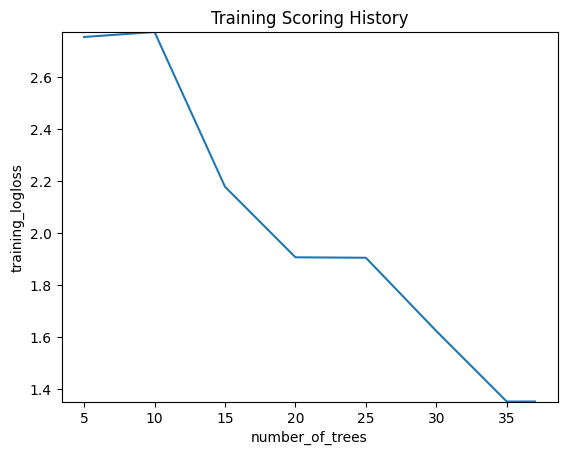

In [113]:
best_model_1.plot()

Важность переменных представляет собой статистическую значимость каждой переменной в данных с точки зрения ее влияния на модель. Переменные перечислены в порядке от наибольшей до наименьшей важности. Процентные значения представляют собой процент важности всех переменных, масштабированный до 100%. Метод вычисления важности каждой переменной зависит от алгоритма.

**Переменная важность**
График важности переменных показывает относительную важность наиболее важных переменных в модели.

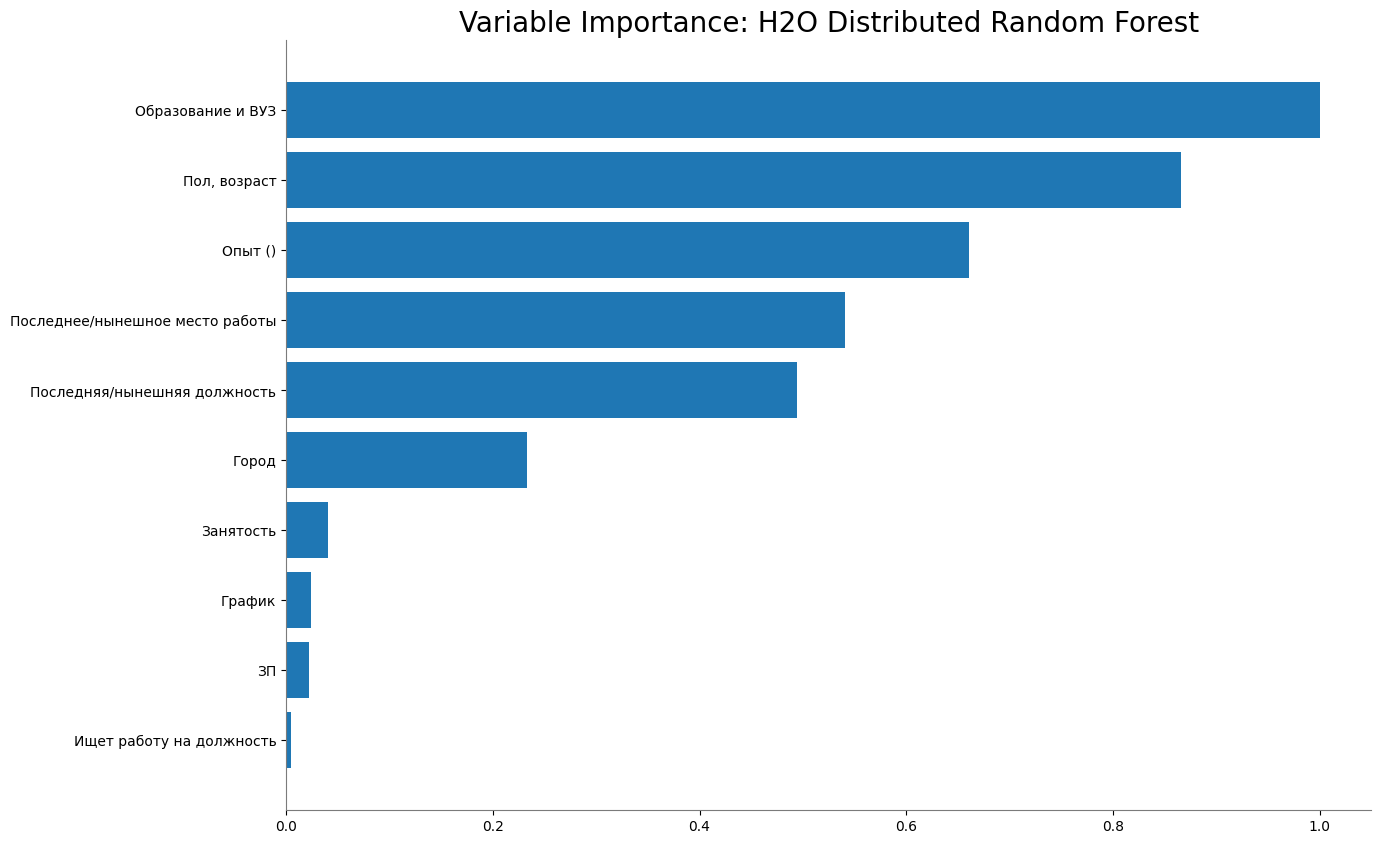

<Figure size 640x480 with 0 Axes>

In [114]:
best_model_1.varimp_plot()

**Тепловая карта важности переменной**
Тепловая карта переменной важности показывает переменную важность для нескольких моделей. Некоторые модели в H2O возвращают важность переменной для версий категориальных столбцов, закодированных с помощью одного горячего (двоичного индикатора) (например, Deep Learning, XGBoost). Чтобы значение переменной важности категориальных столбцов можно было сравнить во всех типах моделей, мы вычисляем суммирование важности переменной для всех функций с горячим кодированием и возвращаем значение одной переменной для исходной категориальной функции. По умолчанию модели и переменные упорядочены по их сходству.

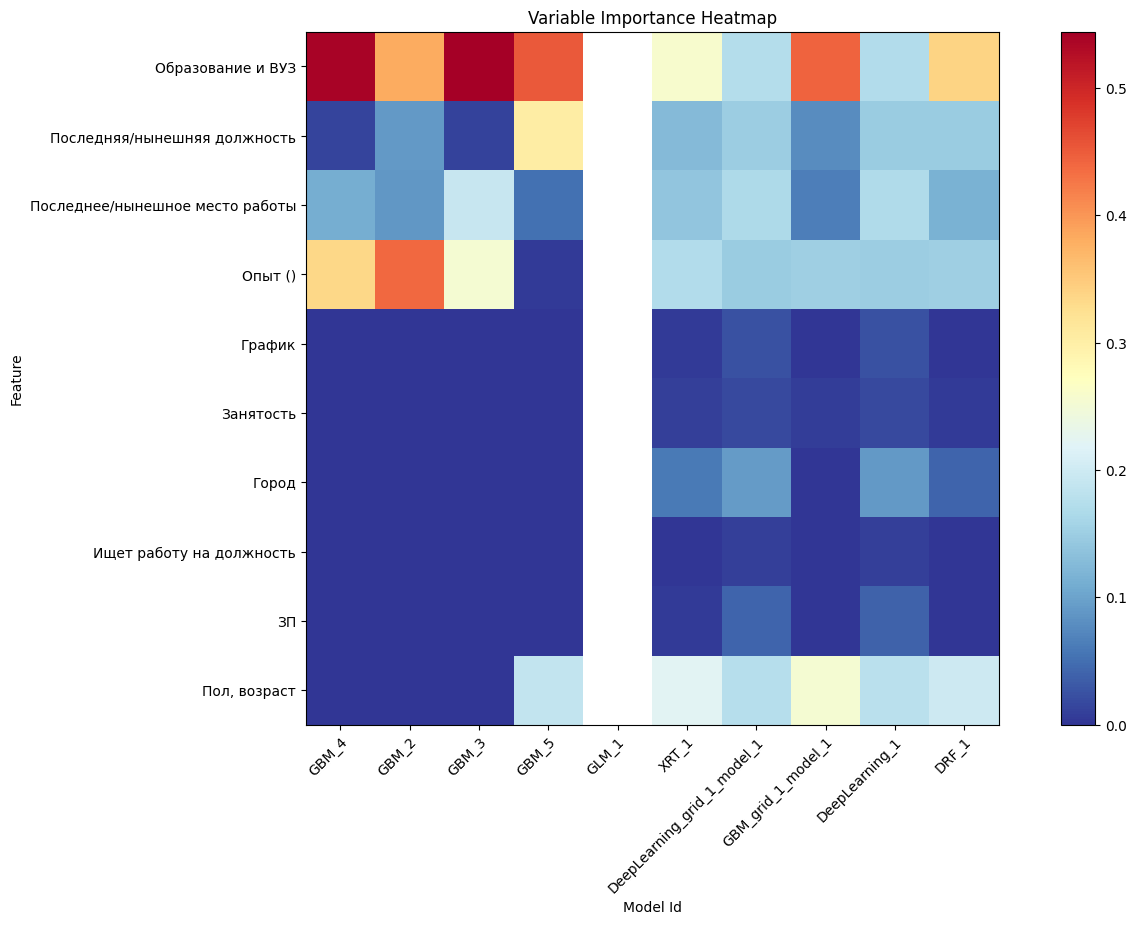

In [115]:
va_plot = aml_1.varimp_heatmap()

**Confusion Matrix**
представляет собой таблицу, показывающую производительность алгоритма с точки зрения ложных срабатываний, ложных отрицательных результатов, истинных положительных результатов и истинных отрицательных результатов.

In [116]:
best_model_1.confusion_matrix()

,да,нет,Error,Rate
да,0.0,9.0,1.0,(9.0/9.0)
нет,0.0,107.0,0.0,(0.0/107.0)
Total,0.0,116.0,0.0776,(9.0/116.0)


### Производительность модели

H2O-3 предоставляет множество показателей, которые можно использовать для оценки контролируемых и неконтролируемых моделей. Показатели в этом разделе охватывают только модели контролируемого обучения, которые различаются в зависимости от типа модели (классификация или регрессия).

In [117]:
perf = best_model_1.model_performance(test)
perf.confusion_matrix()

,да,нет,Error,Rate
да,0.0,1.0,1.0,(1.0/1.0)
нет,0.0,44.0,0.0,(0.0/44.0)
Total,0.0,45.0,0.0222,(1.0/45.0)


**Predict Contributions**
Это включает в себя столбец вклада функции для каждой входной функции. Последний столбец этой таблицы — это смещение модели (столбец один и тот же для каждой строки). Сумма вкладов признаков и члена смещения равна необработанному прогнозу модели. Необработанный прогноз древовидной модели представляет собой сумму прогнозов отдельных деревьев до применения функции обратной связи для получения фактического прогноза. Для распределения Гаусса сумма вкладов равна предсказанию модели.

In [118]:
best_model_1.predict_contributions(train)

contributions progress: |████████████████████████████████████████████████████████| (done) 100%


"Пол, возраст",ЗП,Ищет работу на должность,Город,Занятость,График,Опыт (),Последнее/нынешное место работы,Последняя/нынешняя должность,Образование и ВУЗ,BiasTerm
0.0990667,0.0911369,0.090985,0.0898111,0.0915608,0.091295,0.0982655,0.0870323,0.0916863,0.110788,0.029415
0.0993963,0.0911369,0.090985,0.0939418,0.0916212,0.091295,0.099632,0.102147,0.0996422,0.110788,0.029415
0.0806083,0.0911369,0.090985,0.0783013,0.0652901,0.0920117,0.0974984,0.0792707,0.0879401,0.0913263,0.029415
0.0427311,0.0911369,0.090985,0.0943333,0.0916212,0.0909094,0.0982595,0.101296,0.0988882,0.0992529,0.029415
0.0725394,0.0911369,0.090985,0.0938948,0.0916212,0.091295,0.0975822,0.102147,0.101009,0.111348,0.029415
0.0987347,0.0911369,0.090985,0.0936961,0.0646453,0.0943241,0.0749445,0.0795749,0.0598022,0.109992,0.029415
0.097024,0.0919814,0.090985,0.0741694,0.0916212,0.091295,0.0754569,0.101657,0.0816235,0.0882237,0.029415
0.0598125,0.0911369,0.090985,0.0908793,0.0646453,0.0939316,0.0966179,0.101209,0.081021,0.083307,0.029415
0.0460904,0.0911369,0.090985,0.0931757,0.0915658,0.0935388,0.0979181,0.102876,0.10014,0.082077,0.029415
0.0993963,0.0911369,0.090985,0.0939418,0.0916212,0.091295,0.0982655,0.102147,0.101009,0.110788,0.029415


### Прогноз модели

С помощью H2O-3 вы можете генерировать прогнозы для модели на основе образцов в тестовом наборе

In [119]:
preds = best_model_1.predict(test)
print(preds)


drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%
predict           да       нет
нет        0.0486486  0.951351
нет        0.0742171  0.925783
нет        0.101381   0.898619
нет        0.15       0.85
нет        0.0689189  0.931081
нет        0.027027   0.972973
нет        0.0772201  0.92278
нет        0.0495495  0.95045
нет        0.03861    0.96139
нет        0          1
[67 rows x 3 columns]



In [120]:
best_model_1.save_mojo('best_model.zip')

'/content/best_model.zip/XRT_1_AutoML_7_20230719_123624.zip'

In [121]:
h2o.save_model(model=best_model_1, path="/content/mymodel", force=True)

'/content/mymodel/XRT_1_AutoML_7_20230719_123624'

### Загрузка модели

In [133]:
gdown.download("https://s228vla.storage.yandex.net/rdisk/a0049622545167d42dc0574914962413581c2a39617f8167bc18e88198b841f5/64b81497/2V2cgGRqetkaGS3kvhKGJ2tQunQ9Me4bWPoIN8VGagSTlr-KeAiVNYF57MM1SGcoKyQ4ENEUsw_FjqfcZ_8E-Q==?uid=0&filename=StackedEnsemble_AllModels_1_AutoML_4_20230712_144139.zip&disposition=attachment&hash=pU%2BZDc/ZiaiwXeiE4NoBFMxa5GiP%2BVQEPafdQMPEo9OhqCkg8QZjYyS2Db%2BAxfKnq/J6bpmRyOJonT3VoXnDag%3D%3D&limit=0&content_type=application%2Fzip&owner_uid=269742668&fsize=649647&hid=e5db833f3b9c98610b8fbdeb16b32bc8&media_type=compressed&tknv=v2&rtoken=a7Gj6Kie8Jkj&force_default=no&ycrid=na-bdba2a4b04212699e9a6a845fbcb7e23-downloader21h&ts=600d9d82d13c0&s=c787fb38893feb9b766806ec3ee5c7df79ce3b00ac9d77e7f4b1d21172981446&pb=U2FsdGVkX18sZqUx0KntHm7yRbtQmUA5f2qrxDKKqH_cBwKqswSXG_xX6cPXPLunyEzvbuqvqWUBX6wsdZsSoBAsPoMfW36SvZk3oZqOzME",'model.zip', quiet=True)

'model.zip'

In [134]:
imported_model = h2o.import_mojo("/content/model.zip")

generic Model Build progress: |██████████████████████████████████████████████████| (done) 100%


In [135]:
#Читаем файл в Дата фрейм
df = h2o.import_file("data.csv",header =1)


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [136]:
preds = imported_model.predict(df)
print(preds)


generic prediction progress: |███████████████████████████████████████████████████| (done) 100%
predict             да          нет
да         0.999591     0.000409444
да         0.999341     0.000658733
да         0.999253     0.000747217
нет        0.00227267   0.997727
нет        0.00421762   0.995782
да         0.617156     0.382844
да         0.99943      0.000569717
нет        0.000666161  0.999334
да         0.998609     0.00139136
нет        0.00116623   0.998834
[1030 rows x 3 columns]



/usr/local/lib/python3.10/dist-packages/h2o/job.py:81: UserWarning: Test/Validation dataset column 'Пол, возраст' has levels not trained on: ["", "5 раза снизилась стоимость привлечения лида", "B2G.", "MVC ASP.NET", "P&L - моделью.", "PEST анализ", "ReactJS", "Redmine
Scrum
Управление продуктом
Jira
Kanban
MVP
Agile
Waterfall
UX/UI
CJM
Подготовка ТЗ
User Stories
CustDev
Unit-экономика
Спринты
Водопад
Product менеджер", "SEO продвижения сайтов", "SMM.", ...378 not listed..., "таргетированной рекламы Вконакте", "тестировщиками.", "технические специалисты);", "технологии.", "товарных категорий и продуктов", "управление маркетингом", "холодные звонки", "что повлекло снижение затрат на привлечение тех", "что показалось интереснее. Один раз живём :)"", "что часть продаж через B2B2C (т.е. через дизайнеров интерьера). Их потребности пересеклись с потребностями остальных покупателей. CPS (стоимость привлеченного клиента) снизилась до 3.5 тыс. руб."]
  warnings.warn(w)
/usr/local/lib/python3.10/

In [137]:
df = df.as_data_frame()

In [138]:
preds = preds.as_data_frame()

In [139]:
df = data.join(preds)

In [140]:
df.to_csv('Ответы.csv')
df.head(5)

,Дата отклика,"Пол, возраст",ЗП,Ищет работу на должность,Город,Занятость,График,Опыт (),Последнее/нынешное место работы,Последняя/нынешняя должность,Выполняемые задачи на прошлых местах работ,Обо мне,Ключевые навыки,Образование и ВУЗ,Обновление резюме,Подходит - да/нет,predict,да,нет
119,2023-02-07 00:00:00,"Женщина, 25 лет, родилась 23 июня 1997",35 000 руб.,HR-специалист,"Уфа, Не готова к переезду, готова к редким ком...",полная занятость,полный день,Опыт работы —2 года 10 месяцев,Бодрость,Психолог,Коррекционно-развивающая работа с детьми - инв...,К работе отношусь добросовестно и с необходимо...,MS PowerPoint\nДеловое общение\nРабота в коман...,"Высшее, 2019, Башкирский государственный униве...",27 февраля 2023 в 15:20,нет,нет,0.024297,0.975703
106,2023-01-12 00:00:00,"Женщина, 26 лет, родилась 7 мая 1996",40 000 руб.,HR-специалист,"Уфа, Не готова к переезду, готова к редким ком...","полная занятость, частичная занятость, проектн...",удаленная работа,Опыт работы —4 года 6 месяцев,ООО «Класс Информационные Технологии» https://...,HR менеджер,"Поиск, подбор персонала (линейный, точечный);\...",Опыт в сфере массового и точечного подбора пер...,CRM\nПодбор персонала\nПрямой поиск\nИнтервьюи...,"Высшее, 2018, Уфимский государственный авиацио...",23 марта 2023 в 15:46,нет,нет,0.024297,0.975703
145,2023-02-07 00:00:00,Женщина,20 000 руб.,HR-специалист,"Уфа, Не готова к переезду, не готова к команди...",полная занятость,полный день,Опыт работы —2 месяца,ИП РАМАЗАНОВА Г.А.,Менеджер по работе с клиентами,NaN,NaN,NaN,"Среднее специальное, 2022, Колледж БГПУ им. М....",9 марта 2023 в 10:36,нет,нет,0.024297,0.975703
163,2023-02-14 00:00:00,"Женщина, 45 лет, родилась 15 августа 1977",не указана,Директор медицинской клиники,"Уфа, Готова к переезду: Москва, Санкт-Петербур...",полная занятость,полный день,Опыт работы —25 лет 10 месяцев,Салон красоты,Управляющий,Салон красоты\nУправляющий\nРабота в режиме мн...,"Общий стаж 26 лет, в должности Управляющего 1...",Ведение переговоров\nМатериально-техническое о...,"Высшее, 2000, БГУ Уфа, 1996, Сибайский потитех...",14 февраля 2023 в 11:45,нет,нет,0.003965,0.996035
4,2023-01-11 00:00:00,"Мужчина, 26 лет, родился 21 февраля 1996",150 000 руб.,Project manager,"Пермь, Хочу переехать, готов к командировкам","проектная работа, частичная занятость, полная ...","удаленная работа, гибкий график, полный день",Опыт работы —5 лет 9 месяцев,Индивидуальное предпринимательство / частная п...,Product/Project manager,Переговоры со стейкхолдером\n- Составление ТЗ...,Набрал кучу опыта и хочу с ним найти классную ...,Управление персоналом\nЗаключение договоров\nА...,"Высшее, 2021, Российская академия народного хо...",6 февраля 2023 в 11:18,да,нет,0.004218,0.995782


In [141]:
#Сумма не верных ответов
a=0
for i, row in df.iterrows():

  if row['Подходит - да/нет']!=row['predict']:

    if pd.notnull (row['Подходит - да/нет']):

      a=a+1

print(a)

9


Данная модель хоть и имеет хорошие показатели на обучении и тестировании, но для анализа резюме подходит плохо. Возможно улучшение модели если получиться увеличить датасет для обучения релевантными данными.